In [1]:
from lxml import etree  ##etree是一个非常好的网页解析模块，速度是最快的，也非常的简单,填写一个路径进去，就能找到页面中指定的信息。
from matplotlib.patches import Rectangle#用来绘制正方形（把头在图像上按正方形画出来）
import glob
from PIL import Image#帮我们读取图像

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import torchvision
from torchvision import transforms

import os

In [2]:
images=glob.glob(r'D:/数据集/宠物数据集/dataset/images/*.jpg')#获取所有图像目录
anno=glob.glob(r'D:\数据集\宠物数据集\dataset\annotations\xmls\*.xml')#获取所有标签目录

In [3]:
xml_name=[x.split('\\')[-1].replace('.xml','') for x in anno]#首先对地址通过 // 拆开取最后一项再将后缀替换为空，对标签中的所有地址进行这个操作
imgs=[x for x in images if x.split('\\')[-1].replace('.jpg','') in xml_name]

In [4]:
def to_labels(path):                                         #定义一个函数来进行xml中的标签的提取
    xml=open(r'{}'.format(path)).read()                     #这么做防止输入的字符串转义
    sel=etree.HTML(xml)
    width=int(sel.xpath('//size/width/text()')[0])
    height=int(sel.xpath('//size/height/text()')[0])
    xmin=int(sel.xpath('//bndbox/xmin/text()')[0])
    xmax=int(sel.xpath('//bndbox/xmax/text()')[0])
    ymin=int(sel.xpath('//bndbox/ymin/text()')[0])
    ymax=int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width,ymin/height,xmax/width,ymax/height] #这样返回的是一组值的数，每一个标签返回一组数

In [5]:
labels=[to_labels(p) for p in anno]

In [6]:
species=[]
name=[]
for i in xml_name:
    a=i.split('_')[:-1]#观察得知每个数据的名字都是教 ***_10 前面是名字后面是数字构成，所以用_ 分割后取第一个
    name.append(a)
    if (a not in species):#列表的一个应用
         species.append(a)

    

In [7]:
spe=[]
for i in species:
    a=''
    for j in i:
        a+=' '
        a+=j
    spe.append(a)
names=[]
for i in name:
    a=''
    for j in i:
        a+=' '
        a+=j
    names.append(a)

species_to_idx=dict((v,k) for k,v in enumerate(spe))#根据种类找到序号
idx_to_speic=dict((c,j) for j,c in species_to_idx.items())#根据序号找到种类

for i in range(len(labels)):
    labels[i].append(species_to_idx[names[i]])#按顺序留一份标签名称以便创建ds

In [8]:
idx_to_speic[1]

' american bulldog'

In [10]:
species_to_idx[" Abyssinian"]

0

In [11]:
len(spe)

37

In [12]:
l1,l2,l3,l4,name=list(zip(*labels))
index=np.random.permutation(len(imgs))    
images=np.array(imgs)[index]  

In [13]:
out1 = np.array(l1).astype(np.float32).reshape(-1, 1)[index]
out2 = np.array(l2).astype(np.float32).reshape(-1, 1)[index]
out3 = np.array(l3).astype(np.float32).reshape(-1, 1)[index]
out4 = np.array(l4).astype(np.float32).reshape(-1, 1)[index]
name_1=np.array(name).astype(np.float32).reshape(-1, 1)[index]

In [14]:
i=int(len(imgs)*0.8)

In [15]:
train_imgs=images[:i]
l1_train=out1[:i]
l2_train=out2[:i]
l3_train=out3[:i]
l4_train=out4[:i]
name_train=name_1[:i]

text_imgs=images[i:]
l1_text=out1[i:]
l2_text=out2[i:]
l3_text=out3[i:]
l4_text=out4[i:]
name_text=name_1[i:]

In [16]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [17]:
class Oxford_dataset(data.Dataset):
    def __init__(self, img_paths, out1_label, out2_label, 
                       out3_label, out4_label,name_label, transform):
        self.imgs = img_paths
        self.out1_label = out1_label
        self.out2_label = out2_label
        self.out3_label = out3_label
        self.out4_label = out4_label
        self.name_label = name_label
        self.transforms = transform
        
    def __getitem__(self, index):
        img = self.imgs[index]
        out1_label = self.out1_label[index]
        out2_label = self.out2_label[index]
        out3_label = self.out3_label[index]
        out4_label = self.out4_label[index]
        name_label = self.name_label[index]
        pil_img = Image.open(img) 
        imgs_data = np.asarray(pil_img, dtype=np.uint8)
        if len(imgs_data.shape) == 2:
            imgs_data = np.repeat(imgs_data[:, :, np.newaxis], 3, axis=2)
            img_tensor = self.transforms(Image.fromarray(imgs_data))
        else:
            img_tensor = self.transforms(pil_img)
        return (img_tensor, 
                out1_label, 
                out2_label, 
                out3_label, 
                out4_label,
                name_label)
    
    def __len__(self):
        return len(self.imgs)


In [18]:
train_ds=Oxford_dataset(train_imgs,l1_train,l2_train,l3_train,l4_train,name_train,transform)
text_ds=Oxford_dataset(text_imgs,l1_text,l2_text,l3_text,l4_text,name_text,transform)
train_dl=data.DataLoader(train_ds,batch_size=4,shuffle=True)
text_dl=data.DataLoader(text_ds,batch_size=4)

In [19]:
(img_batch,out1,out2,out3,out4,name2)=next(iter(train_dl))

In [20]:
name2,torch.squeeze(name2),name2.squeeze()

(tensor([[33.],
         [17.],
         [35.],
         [12.]]),
 tensor([33., 17., 35., 12.]),
 tensor([33., 17., 35., 12.]))

In [21]:
species

[['Abyssinian'],
 ['american', 'bulldog'],
 ['american', 'pit', 'bull', 'terrier'],
 ['basset', 'hound'],
 ['beagle'],
 ['Bengal'],
 ['Birman'],
 ['Bombay'],
 ['boxer'],
 ['British', 'Shorthair'],
 ['chihuahua'],
 ['Egyptian', 'Mau'],
 ['english', 'cocker', 'spaniel'],
 ['english', 'setter'],
 ['german', 'shorthaired'],
 ['great', 'pyrenees'],
 ['havanese'],
 ['japanese', 'chin'],
 ['keeshond'],
 ['leonberger'],
 ['Maine', 'Coon'],
 ['miniature', 'pinscher'],
 ['newfoundland'],
 ['Persian'],
 ['pomeranian'],
 ['pug'],
 ['Ragdoll'],
 ['Russian', 'Blue'],
 ['saint', 'bernard'],
 ['samoyed'],
 ['scottish', 'terrier'],
 ['shiba', 'inu'],
 ['Siamese'],
 ['Sphynx'],
 ['staffordshire', 'bull', 'terrier'],
 ['wheaten', 'terrier'],
 ['yorkshire', 'terrier']]

C:\ProgramData\Anaconda3\envs\text\lib\site-packages\numpy\core\fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\ProgramData\Anaconda3\envs\text\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


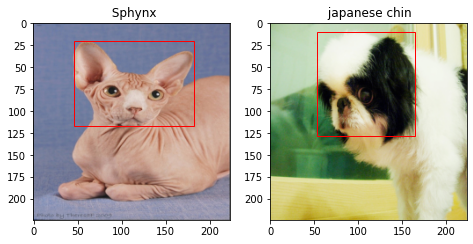

In [22]:
plt.figure(figsize=(12,8))
for i,(img,a1,a2,a3,a4,n) in enumerate(zip(img_batch[:2],out1[:2],out2[:2],out3[:2],out4[:2],name2[:2])):
    img=img.permute(1,2,0).numpy()
    plt.subplot(2,3,i+1)#一共一行两列
    plt.title(idx_to_speic[n.item()])
    plt.imshow(img)
    xmin,ymin,xmax,ymax=a1*224,a2*224,a3*224,a4*224 #注意to_labels()函数阿几个比值的返回顺序，要与其一致
    rect=Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),fill=False,color='red')
    ax=plt.gca()
    ax.axes.add_patch(rect)

In [46]:
resnet = torchvision.models.resnet101(pretrained=True)

In [47]:
in_size=resnet.fc.in_features#通过这个获取resnet全连接层的输入参数量

In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()#继承父类的方法
        self.conv_base=nn.Sequential(*list(resnet.children())[:-1])#初始化卷积部分，使用之前迁移学习的卷积基
        self.fc1=nn.Linear(in_size,1)
        self.fc2=nn.Linear(in_size,1)
        self.fc3=nn.Linear(in_size,1)
        self.fc4=nn.Linear(in_size,1)#因为输出了四个坐标值（xmin,ymin,xmax,ymax）所以设置了4个linear层
        self.fc5=nn.Linear(in_size,35)#还需要输出一个名称序号
    def forward(self,x):
        x=self.conv_base(x)
        x = x.view(x.size(0), -1)
        x1=self.fc1(x)
        x2=self.fc2(x)
        x3=self.fc3(x)
        x4=self.fc4(x)
        name=self.fc5(x)
        return x1,x2,x3,x4,name



In [49]:
model=Net()

In [50]:
if torch.cuda.is_available():
    model.to('cuda')

In [51]:
loss_fn=nn.MSELoss()#因为这是一个回归问题，返回的是一个坐标值，一个具体的数，所以定义的lossfn为这个均方误差
loss_fn2=nn.CrossEntropyLoss()

In [52]:
from torch.optim import lr_scheduler
optim=torch.optim.Adam(model.parameters(),lr=0.0001)
exp_lr_scheduler=lr_scheduler.StepLR(optim,step_size=7,gamma=0.1)

In [57]:
def fit(epoch,model,trainloader,textloader):   #因为这个函数没有输入train_x和train_y所以直接用train_dl和text_dl来算正确率
    running_loss=0
    correct=0                            #通过记录预测正确的个数和样本总数之间的比值来看正确率
    total=0
    model.train()      #使用dropout层和BN层时一定要加这一句表明模型正处于训练状态下  
    for x,y1,y2,y3,y4,name in trainloader:  
        x,y1,y2,y3,y4,name=(x.to('cuda'),y1.to('cuda'),y2.to('cuda'),y3.to('cuda'),y4.to('cuda'),name.to('cuda')) #如果要使用GPU进行加速计算就打开屏蔽 
        y_pred1,y_pred2,y_pred3,y_pred4,name_pred=model(x)
        loss1=loss_fn(y_pred1,y1)
        loss2=loss_fn(y_pred2,y2)
        loss3=loss_fn(y_pred3,y3)
        loss4=loss_fn(y_pred4,y4)
        name_loss=loss_fn2(name_pred,name.squeeze().long())
        loss=loss1+loss2+loss3+loss4+name_loss
        optim.zero_grad()
        loss.backward()
        #name_loss.backward()
        optim.step()
        with torch.no_grad():                  
            running_loss+=loss.item()          #每一批样本的loss
            name_pred=torch.argmax(name_pred,dim=1)
            correct+=(name_pred==name).sum().item()  #每一次正确的个数加到correct里
            total+=name.size(0)
        
    exp_lr_scheduler.step() #如果定义了学习速率衰减可以打开这个屏蔽
    epoch_acc=correct/total 
    epoch_loss=running_loss/len(trainloader.dataset)  #平均loss为一个批次的总loss除以训练的长度
    
    text_correct=0                          #这是对测试数据 ,对于测试数据不用反向传播不用优化
    text_total=0                             
    text_running_loss=0
    model.eval()      #告诉模型现在是预测模式，dropout层不需要发挥作用  
    with torch.no_grad():                  
            for x,y1,y2,y3,y4 ,name in textloader: 
                x,y1,y2,y3,y4,name=(x.to('cuda'),y1.to('cuda'),y2.to('cuda'),y3.to('cuda'),y4.to('cuda'),name.to('cuda'))
                y_pred1,y_pred2,y_pred3,y_pred4,name_pred=model(x)
                loss1=loss_fn(y_pred1,y1)
                loss2=loss_fn(y_pred2,y2)
                loss3=loss_fn(y_pred3,y3)
                loss4=loss_fn(y_pred4,y4)
                name_loss=loss_fn2(name_pred,name.squeeze().long())
                loss=loss1+loss2+loss3+loss4+name_loss                    
                text_running_loss+=loss.item()
                name_pred=torch.argmax(name_pred,dim=1)
                text_correct+=(name_pred==name).sum().item()  #每一次正确的个数加到correct里
                text_total+=name.size(0)
                    
    epoch_test_loss=running_loss/len(textloader.dataset)  
    epoch_text_acc=text_correct/text_total      
    
    print('epoch: ', epoch, 
        'accuracy: ',round(epoch_acc,3),
        'loss： ', round(epoch_loss, 3),
        'test_loss： ', round(epoch_test_loss, 3),
        'text_accuracy: ',round(epoch_text_acc,3)
            )
        
    return epoch_loss, epoch_acc,epoch_test_loss,epoch_text_acc

In [61]:
import copy
epochs=20
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

In [62]:
best_acc=0
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_text_loss,epoch_text_acc =fit(epoch,model,train_dl,text_dl)
    
    if epoch_text_acc > best_acc:
        best_model_wts=copy.deepcopy(model.state_dict()) #达到目前最高的正确率时复制此时的模型权重
        best_acc=epoch_text_acc
    
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_text_loss)
    test_acc.append(epoch_text_acc)

epoch:  0 accuracy:  0.895 loss：  0.153 test_loss：  0.61 text_accuracy:  0.833
epoch:  1 accuracy:  0.951 loss：  0.118 test_loss：  0.47 text_accuracy:  0.869
epoch:  2 accuracy:  0.965 loss：  0.107 test_loss：  0.426 text_accuracy:  0.893
epoch:  3 accuracy:  1.001 loss：  0.075 test_loss：  0.299 text_accuracy:  0.927
epoch:  4 accuracy:  1.003 loss：  0.065 test_loss：  0.258 text_accuracy:  0.883
epoch:  5 accuracy:  1.039 loss：  0.034 test_loss：  0.137 text_accuracy:  0.966
epoch:  6 accuracy:  1.059 loss：  0.023 test_loss：  0.092 text_accuracy:  0.958
epoch:  7 accuracy:  1.064 loss：  0.018 test_loss：  0.071 text_accuracy:  0.97
epoch:  8 accuracy:  1.065 loss：  0.016 test_loss：  0.063 text_accuracy:  0.974
epoch:  9 accuracy:  1.073 loss：  0.014 test_loss：  0.054 text_accuracy:  0.965
epoch:  10 accuracy:  1.061 loss：  0.01 test_loss：  0.04 text_accuracy:  0.946
epoch:  11 accuracy:  1.072 loss：  0.011 test_loss：  0.045 text_accuracy:  0.963
epoch:  12 accuracy:  1.074 loss：  0.011 te

In [64]:
torch.save(model.state_dict(),'pet_dingwei_fenlei.pth')

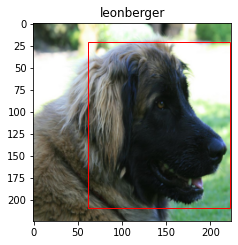

In [105]:
plt.figure(figsize=(12,8))#建一个大点的画布
imgs,_,_,_,_,_=next(iter(text_dl))#”_“是占位符，只是占一个位置，我们不需要dl中的4个坐标值，我们自己预测，我们只取出图片
if torch.cuda.is_available:
    imgs=imgs.to('cuda')#将这张图片放到显卡中
out1,out2,out3,out4,name=model(imgs)#将这张图片放入模型中会返回四个坐标值
name=torch.argmax(name,1)
for i in range(1):
    plt.subplot(2,2,i+1)#创建一个六行一列的画布
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())
    plt.title(idx_to_speic[name[i].item()])
    xmin, ymin, xmax, ymax = out1[i].item()*224, out2[i].item()*224, out3[i].item()*224, out4[i].item()*224
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)   

In [63]:
name

tensor([[22.0343],
        [ 4.8607],
        [36.4287],
        [15.2238]], device='cuda:0', grad_fn=<AddmmBackward>)

In [72]:
imgs,_,_,_,_,_=next(iter(text_dl))
imgs=imgs.to('cuda')

In [73]:
out1,out2,out3,out4,name=model(imgs)

In [74]:
name

tensor([[-4.2151, -0.1533, -3.0432,  1.0634, -3.4614, -4.0534, -3.5327, -2.1285,
         -4.9464,  0.4798, -4.2991, -0.6357,  1.4995, -3.8154, -2.5078, -4.2514,
         -4.8557, -4.7278, -4.7794,  4.6203, -1.7701, -4.0944, -4.3691, -6.0165,
         -4.0346, -5.2762, -4.9054, -5.4255, -1.5579, -3.5334, -4.6146, -3.8497,
         -1.0572, -3.7511, -3.6659],
        [-7.3250, -3.3266,  0.0901, -5.4620, -6.5188, -5.4223, -6.3045, -6.0563,
         -6.2690, -6.1532, -5.9401, 10.4702, -3.3343, -5.3685, -4.3100, -4.1476,
         -6.7206, -4.5157, -7.4372, -4.7020, -4.4818, -7.4707, -7.4257, -4.9565,
         -8.5764, -4.2955, -4.5204, -4.7246, -5.5771, -5.0327, -4.4885, -4.2886,
         -4.7840, -4.1440, -3.8049],
        [-4.1259, -2.6563, -8.3714, -5.1439, -5.0522,  0.0492, -7.3044, -7.9627,
         -2.1281, -4.6738, -4.0870, -7.1635, -5.9016, -3.6146, -7.1752, -1.6565,
         -3.5176, -7.6855, -1.7532, -4.1990, -7.2714, -1.3173, -5.2002, -7.2533,
         11.9056, -5.3974, -4.8058,

In [85]:
torch.argmax(name,dim=1)[1].item()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [89]:
imgs,_,_,_,_,_=next(iter(text_dl))